# Convolutionnal Neural Network (CNN) 

## La classification
La classification est un precessus qui prend une entrer (par exemple une image) et qui repond par une decision en sortie (chien, chat ...)ou la probabiltée de chacune des classes considérée.

## Les réseaux de neurones convolutionnels (CNN)
les CNN sont des réseaux profonds composés de diférentes couches dans le but d'extraire des caractéristiques permettant de différencier entre les classes traité. 

<img src="media/architecture-cnn-fr.png" width="800">

## Types de couche

### Couche de convolution
Le principe de la convolution est de glisser un masque sur l'ensemble des pixels de l'image et de calculer le produit de convolution pour chacun des pixel couvert par ce masque.
<img src="media/convolution-layer-a.png" width="500">
*Remarque : l'étape de convolution peut aussi être généralisée dans les cas 1D et 3D.*
### Couche de pooling
Cette couche a pour but de réduire le spatiale afin de garder que les information pertinantes. En particulier, les types de pooling les plus populaires sont le max et l'average pooling.

|   Max Pooling        |   Avreage Pooling   |
:-------------------:  |  :-------------------------:
|<img src="media/max-pooling-a.png" width="300"> | <img src="media/average-pooling-a.png" width="300">  |

# CNN for image classifiction

Dans ce TP, le but est d'utiliser l'approntissage profond pour faire une classification d'image. Pour cela, la necessité d'une base de donnée est indispenssable. Alors  nous allons utiliser la base CIFARE10.

## CIFARE10

Cette basse est composée de 80 millions d'images éttiqueté. Ces images sont collecté par *Alex Krizhevsky*, *Vinod Nair*, et *Geoffrey Hinton.* 

CIFAR10 est constituée de 10 classes avec 6000 images dans chacune d'elles, amenant à 60 000 images en tous. Cette ensemble d'images est divisé en 2 sous-ensembles : un ensemble pour l'entrînement qui contient 50 000 images et un ensemble pour le test qui contient 10 000 images.

Les classes de cette base de donnée sont : 

* airplane
* automobile
* bird
* cat
* deer
* dog
* frog
* horse
* ship
* truck

Les images de cette base sont de talle 3x32x32 ( c'est des image couleur avec 3 bands spectrales) 


The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. 

<img src="media/cifar10.png">

## Chargement de la base


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)


##########################################################################
#    Chargement/telechargement de la base de TRAIN de CIFARE10           #
##########################################################################

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

##########################################################################
#    Chargement/telechargement de la base de TEST de CIFARE10            #
##########################################################################

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

##########################################################################
#   Definition du module qui fait parcour les donnees                    #
# Paramètres:                                                            #
#       - Batchsize : nbr d'images qui passe en une fois                 #
#       - Shaffle : Vrai      ---> lors de l'entraînement                #
#                   Faux/Vrai ---> lors du test                          #
#                                                                        #
# * On va creer 2 modules : un pour le TRAIN et un pour le TEST          #
##########################################################################

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


### Visualisation de quelque images de l'ensemble d'entraînement

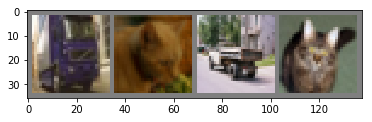

truck   cat truck   cat


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    ##########################################################################################
    #   Il faut transposée les images car PyTorch lis les image en [Chanels, Width, Height]  #
    #   et pour les voir il faut qu'elles soient [Width, Height, Chanels]                    #
    ##########################################################################################
    plt.imshow(np.transpose(npimg, (1, 2, 0))) 
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

### Création d'un CNN

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(in_features=16 * 5 * 5, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


### Definition de la fonction Loss et de l'optimizeur

Let’s use a Classification Cross-Entropy loss and SGD with momentum.

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### Entrînement du reseau


In [7]:
###############################################
#   * Fixer les paramètres de l'entrînement   #
###############################################
  
nb_epoch = 10 # Le nombre d'epoch
loss_list = [] # liste qui va contenir la valeur du loss a chaque epoch
for epoch in range(nb_epoch):  # loop over the dataset multiple times

    running_loss = 0.0
    nb_data = 0.
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)              # Forward
        loss = criterion(outputs, labels)
        loss.backward()                    # Backward
        optimizer.step()                   # optimize
 
        # print statistics
        running_loss += loss.item()
        
        nb_data += 1.
        
    running_loss = running_loss / nb_data
    loss_list.append(running_loss)    
    print("Epoch ", epoch, "; train loss = ", running_loss) 
    
torch.save({
                'nb_epoch': nb_epoch,
                'model' : net.state_dict(),
                'listLoss': loss_list,
            }, "modelNN.pth")

print('Finished Training and save the model as `modelNN.pth`')

Epoch  0 ; train loss =  1.6877961233079433
Epoch  1 ; train loss =  1.3119387872886659
Epoch  2 ; train loss =  1.1793886017531157
Epoch  3 ; train loss =  1.0832727863208949
Epoch  4 ; train loss =  1.017185084624961
Epoch  5 ; train loss =  0.9607083728414029
Epoch  6 ; train loss =  0.917620547067821
Epoch  7 ; train loss =  0.879022120722048
Epoch  8 ; train loss =  0.8421289572067745
Epoch  9 ; train loss =  0.815495071712276
Finished Training and save the model as `modelNN.pth`


### Ploter la courbe du loss

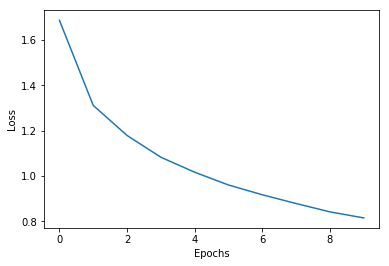

In [8]:
plt.plot(range(len(loss_list)), loss_list)

plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.show()

### Test the network on the test data

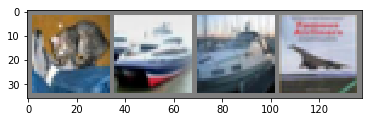

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship  ship  ship


In [9]:
# Charger un batch de l'ensemble de test
dataiter = iter(testloader)
images, labels = dataiter.next()

# Passer le batch dans le reseau
outputs = net(images)
predicted1 = torch.softmax(outputs.data, 1)

_, predicted2 = torch.max(predicted1, 1)


# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
print('Predicted: ', ' '.join('%5s' % classes[predicted2[j]] for j in range(4)))

## Evaluation du model

### Taux de reconnaissance globale

In [10]:
correct = 0.
total = 0.
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %f %%' % ( 100. * correct / total))

Accuracy of the network on the 10000 test images: 59.890000 %


### Taux de reconnaissance de chacune des classes

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %f %%' % (classes[i], 100. * class_correct[i] / class_total[i]))